# TODO

- loi normale
- loi gamma
- dataset
- pénalisation lasso
- pénalisation group lasso

In [1]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import math

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline 

In [3]:
import numpy
numpy.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [4]:
import perf
import metrics

In [5]:
from importlib import reload
reload(perf)

<module 'perf' from '\\\\siege.axa-fr.intraxa\\donneessiege\\User_data_PGEN\\data\\S628057\\Documents\\git\\pricing-tool\\perf.py'>

In [6]:
def rmse(generator, model, size=1000):
    values = np.zeros(size)
    for i in range(size):
        x, y, exposure = generator.get_observation()
        y_pred = model.pred(x, exposure)
        values[i] = y - y_pred
    return np.sqrt(np.sum(np.square(values)) / size)   

In [7]:
class PoissonSampleGenerator:
    
    def __init__(self, size):
        self.size = size
        self.intercept = -1
        self.coeffs = np.random.randn(size) / 10
        self.noise_factor = 1
        
    def get_observation(self):
        x = np.random.randn(self.size)
        exposure = np.random.rand(1)
        y = np.exp(self.intercept + np.inner(x, self.coeffs) + np.random.randn(1) * self.noise_factor / 100)
        y *= exposure
        return x, y, exposure

In [8]:
class Dataset:
    
    def __init__(self):
        pass

In [9]:
import pandas as pd

class TrainingFileReader:
    
    def __init__(self, filename, features, exposure, target):
        self.filename = filename
        self.features = features
        self.exposure = exposure
        self.target = target
        usecols = features + [exposure, target]
        self.df = pd.read_csv(filename, sep=',', usecols=usecols, dtype=str, nrows=300000)
        self.df['Intercept'] = 1
        features = ['Intercept'] + features
        self.observations = pd.get_dummies(self.df[features])
        self.modalities = list(self.observations)
        self.observations[self.exposure] = self.df[self.exposure]
        self.observations[self.target] = self.df[self.target]
        train, test = train_test_split(self.observations, test_size=0.1)
        self.train = train.astype('float')
        self.test = test.astype('float')
        self.size = self.train.shape[0]
        mask = [0] * len(self.modalities)
        train_list = np.array(list(self.train))
        for i in range(len(self.modalities)):
            mask[i] = int(np.where(self.modalities[i] == train_list)[0])
        self.mask = mask
        self.exposure_index = int(np.where(exposure == train_list)[0])
        self.target_index = int(np.where(target == train_list)[0])
        self.train = self.train.as_matrix()
        self.test = self.test.as_matrix()
        self.train_data = self.train[:, self.mask]
        self.exposure_data = self.train[:, self.exposure_index]
        self.target_data = self.train[:, self.target_index]
        
    def get_observation(self):
        index = np.random.randint(self.size)
        x = self.train_data[index]
        y = self.target_data[index]
        exposure = self.exposure_data[index]
        return x, y, exposure 
    
    def pred(self, model):
        exposure = self.test[:, self.exposure_index]
        y = self.test[:, self.target_index]
        y_pred = np.exp(np.inner(self.test[:,self.mask], model.coeffs) + np.log(exposure))
        return (y, y_pred, exposure)

In [10]:
class PoissonImplicitSGD:
    
    def __init__(self, dataset):
        self.dataset = dataset
        self.size = dataset.train.shape[1] - 2
        self.coeffs = np.zeros(self.size)
        
    def fit_observation(self, x, y, exposure=0, learning_rate=0.1):
        # get data 3 micros
        y_pred = math.exp(np.inner(self.coeffs, x)) * exposure  # 6 micros
        r = learning_rate * (y - y_pred)
        x_squared = np.sum(x**2) # 7 micros
        x1, x2 = 0, r
        y1 = x1 - learning_rate * (y - y_pred * math.exp(x_squared * x1)) # 1 micros
        y2 = x2 - learning_rate * (y - y_pred * math.exp(x_squared * x2)) # 1 micros
        for i in range(30): # 3 micros
            if abs(y2) < 1e-12:
                break
            x3 = (x1 * y2 - x2 * y1) / (y2 - y1)
            y3 = x3 - learning_rate * (y - y_pred * math.exp(x_squared * x3))
            x1, y1 = x2, y2
            x2, y2 = x3, y3
        self.coeffs += x2 * x  # 4 micros
        
    def pred(self, x, exposure=0):
        return np.exp(np.inner(self.coeffs, x)) * exposure

In [11]:
g = TrainingFileReader('c:/data/mrh/axaf_mrh_tot_freq_tot.csv', 
                       ['ddea_quant_cm_10',
                        'HAB_nb_pieces',
                        'HAB_qual',
                        'HAB_anclg',
                        'CLI_age',
                        #'POL_mtcapass',
                        'HAB_habit',
                        'CLI_sex',
                        'POL_tr_tx_objv',
                        'POL_fract',
                        'annee',
                        'CLI_nb_enfant',
                       ], 'anpol', 'nbsinDDE')

In [16]:
model = PoissonImplicitSGD(g)

iterations = 2000000
e_train = []
e_test = []
gini = []
ldeviance = []
coeffs = model.coeffs.copy()

for i in range(1, 100000):
    model.fit_observation(*g.get_observation(), learning_rate=i**-1)

for i in range(1, iterations + 1):
    model.fit_observation(*g.get_observation(), learning_rate=0.001)#1*i**-0.75)
    coeffs += model.coeffs
    if i % 100000 == 0 :
        mstar = model = PoissonImplicitSGD(g)
        mstar.coeffs = coeffs / i
        y, y_pred, exposure = g.pred(mstar)
        e_train.append(perf.root_mean_square_error(y, y_pred))
        e_test.append(0)
        gini.append(metrics.gini_emblem_fast(y, y_pred, exposure))
        ldeviance = np.log(metrics.poisson_deviance(y, y_pred, exposure))
        print('iteration: ', i)
        print('mean:', np.mean(y_pred) / np.mean(y))
        print('rmse:', e_train[-1] , e_test[-1])
        print('gini:', gini[-1])
        print('deviance:', ldeviance)
        print('------------')

iteration:  100000
mean: 0.992631028449
rmse: 0.185827531032 0
gini: 0.196850394294
deviance: 8.74384760518
------------
iteration:  200000
mean: 0.984442864275
rmse: 0.18562194308 0
gini: 0.256982326264
deviance: 8.73484754931
------------
iteration:  300000
mean: 0.983227283172
rmse: 0.18552192913 0
gini: 0.277213160306
deviance: 8.73065586533
------------
iteration:  400000
mean: 0.977993300867
rmse: 0.185448587109 0
gini: 0.288841489312
deviance: 8.72763198253
------------
iteration:  500000
mean: 0.978476468998
rmse: 0.18539560021 0
gini: 0.295288271922
deviance: 8.72555768022
------------
iteration:  600000
mean: 0.975538349844
rmse: 0.185363432894 0
gini: 0.299461121711
deviance: 8.72421419847
------------
iteration:  700000
mean: 0.976549873382
rmse: 0.185331231757 0
gini: 0.302525959053
deviance: 8.72304609335
------------
iteration:  800000
mean: 0.974881793057
rmse: 0.185307148279 0
gini: 0.304971992276
deviance: 8.72211280298
------------
iteration:  900000
mean: 0.97242065

In [17]:
for k, v in zip(g.modalities, np.exp(model.coeffs)):
    print(k, ':', v)

Intercept : 0.485968353324
ddea_quant_cm_10_0 : 0.933558267149
ddea_quant_cm_10_1 : 0.920877770786
ddea_quant_cm_10_10 : 1.31945803735
ddea_quant_cm_10_2 : 0.860636167345
ddea_quant_cm_10_3 : 0.806209142352
ddea_quant_cm_10_4 : 0.850151718799
ddea_quant_cm_10_5 : 0.86347599068
ddea_quant_cm_10_6 : 0.796937936469
ddea_quant_cm_10_7 : 0.961248671559
ddea_quant_cm_10_8 : 1.0004177294
ddea_quant_cm_10_9 : 1.09752226263
HAB_nb_pieces_1 : 0.844102306217
HAB_nb_pieces_10 : 1.02171845999
HAB_nb_pieces_11 : 1.00371858054
HAB_nb_pieces_12 : 1.00722465941
HAB_nb_pieces_13 : 1.01173765058
HAB_nb_pieces_14 : 1.01090706791
HAB_nb_pieces_15 : 1.00399920657
HAB_nb_pieces_2 : 0.795641663847
HAB_nb_pieces_3 : 0.831599247891
HAB_nb_pieces_4 : 0.846851889219
HAB_nb_pieces_5 : 0.904331139596
HAB_nb_pieces_6 : 0.967510439962
HAB_nb_pieces_7 : 1.0485721507
HAB_nb_pieces_8 : 0.993184226933
HAB_nb_pieces_9 : 1.06311559661
HAB_qual_L : 0.598637055113
HAB_qual_P : 0.81179130021
HAB_anclg_5-10ans : 0.940142422165

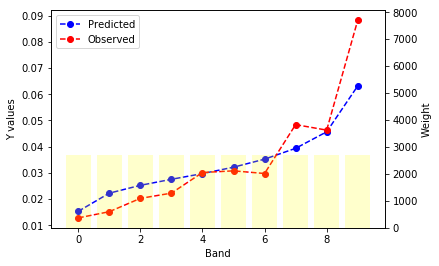

In [18]:
metrics.plot_lift_curve(y, y_pred, exposure)

In [841]:
y_pred = np.mean(y)/np.mean(y_pred)*y_pred
print('iteration: ', i)
print('mean:', np.mean(y_pred) / np.mean(y))
print('rmse:', perf.root_mean_square_error(y, y_pred))
print('gini:', metrics.gini_emblem_fast(y, y_pred, exposure))
print('deviance:', np.log(metrics.poisson_deviance(y, y_pred, exposure)))
print('------------')

iteration:  2000000
mean: 1.0
rmse: 0.184639460727
gini: 0.346075919498
deviance: 8.68487107208
------------


In [816]:
np.mean(y_pred),np.mean(y)

(0.031821881916350721, 0.031566666666666666)

In [830]:
np.log(np.mean(y_pred)),np.log(np.mean(y))

(-3.461337782982655, -3.4556535674582141)

In [540]:
%%timeit
g.get_observation()

The slowest run took 22.91 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.67 µs per loop


In [ ]:
for i in range(100):
    x, y, exposure = g.get_observation()
    y_pred = model.pred(x, exposure)
    print(x, y, y_pred, exposure)

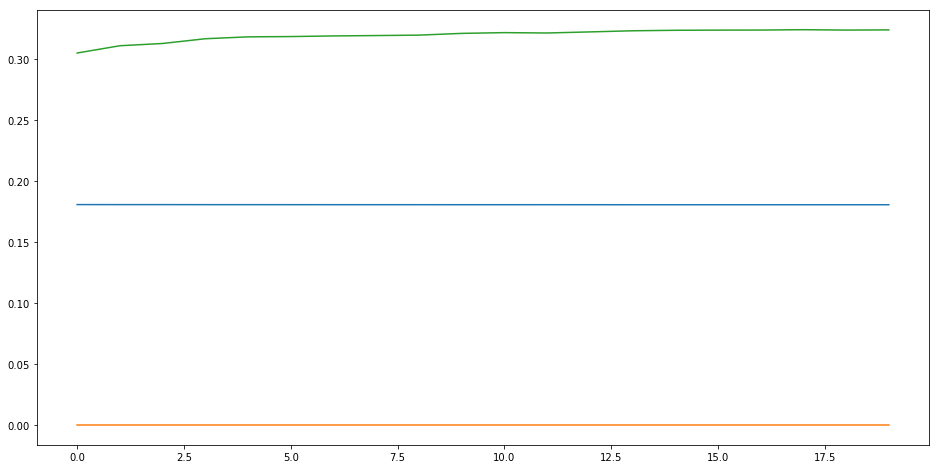

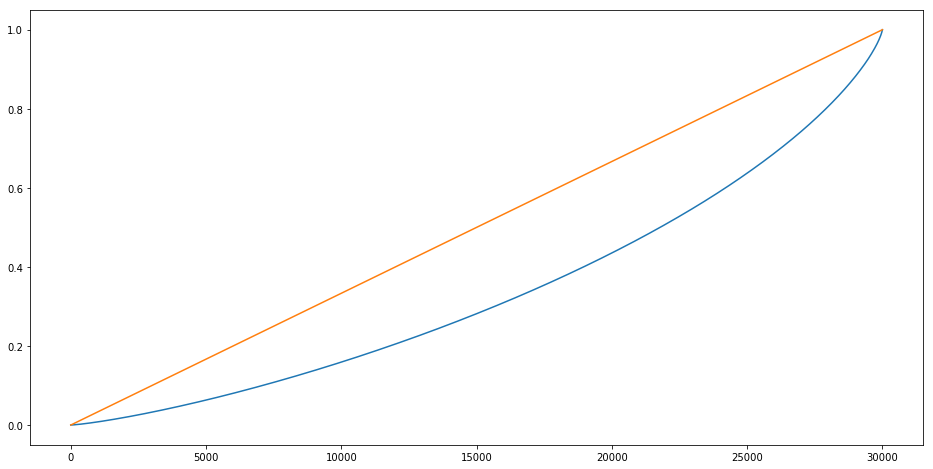

In [779]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
line, = ax.plot(e_train)
ax = fig.add_subplot(111)
line, = ax.plot(e_test)
ax = fig.add_subplot(111)
line, = ax.plot(gini)
plt.show()
perf.plot_gini(y_pred, exposure)